# Repository Publication Analysis with MAG

#### In this tutorial, we demonstrate an example to analyze repository publications with MAG data.
1. List top 10 repository venues with number of papers.
1. Overall repository distribution over domains and venues.
1. Plot the number of repository papers by year for the past 40 years.

## Prerequisites

Complete these tasks before you begin this tutorial:

- Setting up provisioning of Microsoft Academic Graph to an Azure blob storage account. See [Get Microsoft Academic Graph on Azure storage](https://docs.microsoft.com/academic-services/graph/get-started-setup-provisioning).
- Setting up Azure Databricks service. See [Set up Azure Databricks](https://docs.microsoft.com/academic-services/graph/get-started-setup-databricks).

## Gather the information

Before you begin, you should have these items of information:

- The name of your Azure Storage (AS) account containing MAG dataset from [Get Microsoft Academic Graph on Azure storage](https://docs.microsoft.com/academic-services/graph/get-started-setup-provisioning#note-azure-storage-account-name-and-primary-key).
- The access key of your Azure Storage (AS) account from [Get Microsoft Academic Graph on Azure storage](https://docs.microsoft.com/academic-services/graph/get-started-setup-provisioning#note-azure-storage-account-name-and-primary-key).
- The name of the container in your Azure Storage (AS) account containing MAG dataset.

## Import notebooks

- [Import](https://docs.databricks.com/user-guide/notebooks/notebook-manage.html#import-a-notebook) samples/pyspark/MagClass.py in MAG dataset under your working folder.
- [Import](https://docs.databricks.com/user-guide/notebooks/notebook-manage.html#import-a-notebook) this notebook under the same folder.

### Initialize storage account and container details

  | Variable  | Value | Description  |
  | --------- | --------- | --------- |
  | AzureStorageAccount | Replace **`<AzureStorageAccount>`** | This is the Azure Storage account containing MAG dataset. |
  | AzureStorageAccessKey | Replace **`<AzureStorageAccessKey>`** | This is the Access Key of the Azure Storage account. |
  | MagContainer | Replace **`<MagContainer>`** | This is the container name in Azure Storage account containing MAG dataset, usually in the form of `mag-yyyy-mm-dd`. |

In [0]:
AzureStorageAccount = '<AzureStorageAccount>'
AzureStorageAccessKey = '<AzureStorageAccessKey>'
MagContainer = '<MagContainer>'

### Define MicrosoftAcademicGraph class

Run the MagClass notebook to define MicrosoftAcademicGraph class.

In [0]:
%run "./MagClass"

### Create a MicrosoftAcademicGraph instance to access MAG dataset
Use account=AzureStorageAccount, key=AzureStorageAccessKey, container=MagContainer.

In [0]:
MAG = MicrosoftAcademicGraph(account=AzureStorageAccount, key=AzureStorageAccessKey, container=MagContainer)

### Import python libraries

In [0]:
from pyspark.sql import functions as F
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd

### Load MAG data

In [0]:
Paper = MAG.getDataframe('Papers')
Journal = MAG.getDataframe('Journals')
Fos = MAG.getDataframe('FieldsOfStudy')
PaperAuthorAff = MAG.getDataframe('PaperAuthorAffiliations')
PaperFos = MAG.getDataframe('PaperFieldsOfStudy')
PaperUrls = MAG.getDataframe('PaperUrls')

### Get all repository publications with venue, year, and domain
- Repository venues are stored in Journal table, for example: bioRxiv has JournalId 2734324842.
- ArXiv is separated into 153 different venues in Journal table corresponding to the categories in arxiv.org, such as `arXiv: High Energy Physics - Theory`, `arXiv: General Mathematics`. For simplicity, this tutorial treats arXiv as a single venue.

In [0]:
# Get all repository papers
repoPaper = Paper.where(Paper.DocType == 'Repository') \
  .join(Journal, Paper.JournalId == Journal.JournalId , 'left_outer') \
  .select(Paper.PaperId, Paper.Year, F.when( Journal.DisplayName.startswith('arXiv:'), 'arXiv').otherwise( Journal.DisplayName).alias('VenueName'))

In [0]:
# Workaround for SSRN and ChemInform papers not having correct DocType.
# Will remove this cell once the data is fixed.
ssrn = PaperUrls.where(PaperUrls.SourceUrl.contains("ssrn.com/")) \
  .join(Paper, Paper.PaperId == PaperUrls.PaperId, 'inner') \
  .select(Paper.PaperId, Paper.Year, F.lit('Social Science Research Network').alias('VenueName'))

cheminform = Paper \
  .join(Journal, Paper.JournalId == Journal.JournalId, 'inner') \
  .where(Journal.DisplayName == 'ChemInform') \
  .select(Paper.PaperId, Paper.Year, Journal.DisplayName.alias('VenueName'))

repoPaper = repoPaper.union(ssrn).union(cheminform) 

#### Choose only top-level fields of study (level 0) as top level domains

In [0]:
repoPaper = repoPaper\
  .join(PaperFos, PaperFos.PaperId == repoPaper.PaperId , 'inner') \
  .join(Fos, Fos.FieldOfStudyId == PaperFos.FieldOfStudyId, 'inner') \
  .where(Fos.Level == 0)  \
  .select(repoPaper.PaperId, repoPaper.Year, repoPaper.VenueName, PaperFos.FieldOfStudyId, Fos.DisplayName.alias('Domain'))

# convert Spark dataFrame to Pandas dataFrame for graph drawing
repoPandas = repoPaper.toPandas()

### 1. List top 10 repository venues with number of papers

In [0]:
repoVenueStat = repoPandas.groupby('VenueName')['PaperId'].nunique().reset_index(name = 'PaperCount')
repoVenueStat = repoVenueStat.sort_values(by =['PaperCount'], ascending = False)
repoVenueStat['Rank'] = np.arange(len(repoVenueStat))
repoVenueStat.head(10)

Out[11]:

,VenueName,PaperCount,Rank
2173,arXiv,1473470,0
1858,Social Science Research Network,742142,1
307,ChemInform,722214,2
2174,bioRxiv,121275,3
2187,viXra,28255,4
1511,National Bureau of Economic Research,26874,5
2182,medRxiv,16473,6
784,IACR Cryptology ePrint Archive,8929,7
91,American Journal of Agricultural Economics,7436,8
800,IMF Working Papers,6849,9


### 2. Overall repository distribution over domains and venues

In [0]:
repoDomain = repoPandas.groupby(['Domain'])['PaperId'].nunique().reset_index(name = 'PaperCount').sort_values(by = ['PaperCount'], ascending = False)
# group domains with paper count less than 100k as 'Others'
repoDomain.loc[repoDomain.PaperCount < 100000, 'Domain'] = 'Others'
repoDomain = repoDomain.groupby(['Domain'])['PaperCount'].sum().reset_index().sort_values(by = ['PaperCount'], ascending = False)

repoVenue = repoPandas.groupby(['VenueName'])['PaperId'].nunique().reset_index(name = 'PaperCount').sort_values(by = ['PaperCount'], ascending = False)
# group venues with paper count less than 200k as 'Others'
repoVenue.loc[repoVenue.PaperCount < 200000, 'VenueName'] = 'Others'
repoVenue = repoVenue.groupby(['VenueName'])['PaperCount'].sum().reset_index().sort_values(by = ['PaperCount'], ascending = False)

Out[13]:

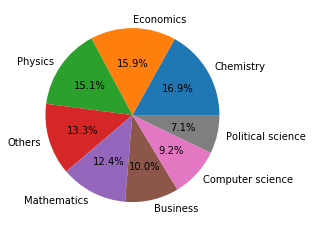

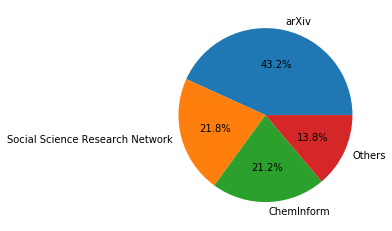

Text(0, 0.5, '')

In [0]:
ax = repoDomain.plot.pie(y='PaperCount', autopct='%1.1f%%', labels=repoDomain['Domain'], legend =False )
ax.set_ylabel('')

ax1 = repoVenue.plot.pie(y='PaperCount', autopct='%1.1f%%', labels=repoVenue['VenueName'], legend =False )
ax1.set_ylabel('')

### 3. Plot the number of repository papers by year for the past 40 years (1981-2020)

In [0]:
repoPaperCount = repoPandas[(repoPandas['Year']>=1981) & (repoPandas['Year']<= 2020)]\
  .groupby(['Year','VenueName'])['PaperId'].nunique().reset_index(name = 'PaperCount')
repoPaperCount.sort_values(['Year', 'PaperCount'])
repoPaperCount_pivot = pd.pivot_table(repoPaperCount, values='PaperCount', index='Year', columns = ['VenueName'], aggfunc=np.sum, fill_value =0)
tbp = repoPaperCount_pivot.reset_index()

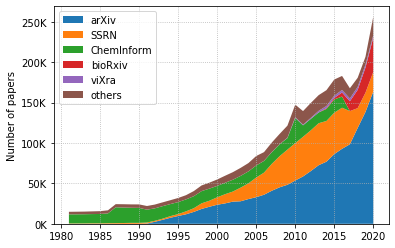

In [0]:
fig, ax = plt.subplots()

# Select top venues: arXiv, ChemInform, bioRxiv, viXra and SSRN. Group rest of the venues as 'others'.
venueList = list(tbp)
venueList.remove('arXiv')
venueList.remove('ChemInform')
venueList.remove('bioRxiv')
venueList.remove('viXra')
venueList.remove('Social Science Research Network')
tbp['others']=tbp[venueList].sum(axis=1)

ax.set_ylabel('Number of papers')
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000) + 'K'))

ax.stackplot(tbp.Year,  tbp.arXiv, tbp['Social Science Research Network'], tbp.ChemInform, tbp.bioRxiv, tbp.viXra, tbp.others,
            labels =[ 'arXiv', 'SSRN' ,'ChemInform', 'bioRxiv', 'viXra', 'others'])
ax.tick_params(axis='y')
ax.legend(loc='upper left')
ax.grid(linestyle=':')